In [1]:
# General 
import sys
import math
import numpy as np
import pandas as pd
#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
#GPyTorch
import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import tqdm
#Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
class WindCalculator:
    def __init__(self,windfield_params):
        self.windfield_params = windfield_params
        self.windfield_params = windfield_params
        self.use_custom_windfield = self.windfield_params['use_custom_windfield']
        self.wind_direction = self.windfield_params['wind_direction']
        self.wind_velocity = self.windfield_params['wind_velocity']
        wind_norm = np.sqrt(self.wind_direction[0] ** 2 + self.wind_direction[1] ** 2 + self.wind_direction[2] ** 2)
        self.wind_direction = self.wind_direction / wind_norm
        if self.use_custom_windfield:
            windfield_path= self.windfield_params['windfield_path']
            try:
                f = open(windfield_path)
            except:
                print("File '" + windfield_path + "' does not exist!")
                exit(1)

            name = ""
            data = dict()
            for i in range(26):
                val = f.readline()
                if i % 2 == 0:
                    val = str(val)
                    val = val.replace(" ", "")
                    val = val.replace("\n", "")
                    val = val.replace(":", "")
                    name = val
                else:
                    line = np.fromstring(str(val), sep=" ")
                    if (len(line) == 1):
                        line = line[0]
                    data[name] = line

            self.min_x_ = data["min_x"]
            self.min_y_ = data["min_y"]
            self.n_x_ = int(data["n_x"])
            self.n_y_ = int(data["n_y"])
            self.res_x_ = data["res_x"]
            self.res_y_ = data["res_y"]
            self.vertical_spacing_factors_ = data["vertical_spacing_factors"]
            self.bottom_z_ = data["bottom_z"]
            self.top_z_ = data["top_z"]
            self.u_vec_ = data["u"]
            self.v_vec_ = data["v"]
            self.w_vec_ = data["w"]

            self.n_z = len(self.vertical_spacing_factors_)

    def linear_interpolation(self, position, values, points):
        value = values[0] + (values[1] - values[0]) / (points[1] - points[0]) * (position - points[0])
        return value

    def bilinear_interpolation(self, position, values, points):
        intermediate_values = np.array([self.linear_interpolation(position[0], values[0:], points[0:]),
                                        self.linear_interpolation(position[0], values[2:], points[2:])])
        value = self.linear_interpolation(position[1], intermediate_values, points[4:])
        return value

    def trilinear_interpolation(self, position, values, points):
        intermediate_values = np.array([self.linear_interpolation(position[2], values[0:], points[0:]),
                                        self.linear_interpolation(position[2], values[2:], points[2:]),
                                        self.linear_interpolation(position[2], values[4:], points[4:]),
                                        self.linear_interpolation(position[2], values[6:], points[6:])])
        value = self.bilinear_interpolation(position[0:],intermediate_values, points[8:])
        return value

    def calculate_windfield(self, link_position):

        if self.use_custom_windfield:
            # Calculate x,y index just smaller than aircraft position or equal to
            x_inf = math.floor((link_position[0] - self.min_x_) / self.res_x_)
            y_inf = math.floor((link_position[1] - self.min_y_) / self.res_y_)

            # In case aircraft is on one of the boundary surfaces at max_x or max_y,
            # decrease x_inf, y_inf by one to have x_sup, y_sup on max_x, max_y.
            if x_inf == self.n_x_ - 1:
                x_inf = self.n_x_ - 2
            if y_inf == self.n_y_ - 1:
                y_inf = self.n_y_ - 2

            # Calculate x,y index just larger than aircraft position
            x_sup = x_inf + 1
            y_sup = y_inf + 1

            # Save grid points enclosing the aircraft in an array
            n_vertices = 8
            idx_x = np.array([x_inf, x_inf, x_sup, x_sup, x_inf, x_inf, x_sup, x_sup])
            idx_y = np.array([y_inf, y_inf, y_inf, y_inf, y_sup, y_sup, y_sup, y_sup])

            # Find vertical factors in each of the four surrounding
            # grid columns, and their minimal/maximal value.
            n_columns = 4
            vertical_factors_columns = np.empty(n_columns)
            for i in range(n_columns):
                vertical_factors_columns[i] = (link_position[2] - self.bottom_z_[
                    idx_x[2 * i] + idx_y[2 * i] * self.n_x_]) \
                                              / (self.top_z_[idx_x[2 * i] + idx_y[2 * i] * self.n_x_] -
                                                 self.bottom_z_[idx_x[2 * i] + idx_y[2 * i] * self.n_x_])

            # Find minimal and maximal vertical factor
            vertical_factors_min = min(min(min(
                vertical_factors_columns[0], vertical_factors_columns[1]),
                vertical_factors_columns[2]), vertical_factors_columns[3])
            vertical_factors_max = max(max(max(
                vertical_factors_columns[0], vertical_factors_columns[1]),
                vertical_factors_columns[2]), vertical_factors_columns[3])

            # Check if aircraft is out of wind field or not, and act accordingly.
            if (x_inf >= 0 and y_inf >= 0 and vertical_factors_max >= 0 and
                    x_sup <= (self.n_x_ - 1) and y_sup <= (self.n_y_ - 1) and vertical_factors_min <= 1):
                # Find indices in z-direction for each of the vertices.If link is not
                # within the range of one of the columns, set to lowest or highest two.
                idx_z = [0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1]
                for i in range(n_columns):
                    if vertical_factors_columns[i] < 0:
                        # Link z - position below lowest grid point of that column
                        idx_z[2 * i + 1] = 1
                    elif vertical_factors_columns[i] >= 1:
                        # Link z-position above highest grid point of that column
                        idx_z[2 * i] = len(self.vertical_spacing_factors_) - 2
                    else:
                        # Link z-position between two grid points in that column.
                        for j in range(len(vertical_factors_columns) - 1):
                            if self.vertical_spacing_factors_[j] <= vertical_factors_columns[i] < \
                                    self.vertical_spacing_factors_[j + 1]:
                                idx_z[2 * i] = j
                                idx_z[2 * i + 1] = j + 1
                                break

                # Extract the wind velocities corresponding to each vertex
                wind_at_vertices = np.empty([8, 3])
                for i in range(n_vertices):
                    wind_at_vertices[i, 0] = self.u_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]
                    wind_at_vertices[i, 1] = self.v_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]
                    wind_at_vertices[i, 2] = self.w_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]

                # Extract the relevant coordinate of every point needed for trilinear interpolation
                n_points_interp_z = 8
                n_points_interp_x = 4
                n_points_interp_y = 2
                interpolation_points = np.empty(n_points_interp_x + n_points_interp_y + n_points_interp_z)
                for i in range(n_points_interp_x + n_points_interp_y + n_points_interp_z):
                    if i < n_points_interp_z:
                        interpolation_points[i] = (self.top_z_[idx_x[i] + idx_y[i] * self.n_x_] - self.bottom_z_[
                            idx_x[i] + idx_y[i] * self.n_x_]) \
                                                  * self.vertical_spacing_factors_[idx_z[i]] + self.bottom_z_[
                                                      idx_x[i] + idx_y[i] * self.n_x_]
                    elif n_points_interp_z <= i < n_points_interp_x + n_points_interp_z:
                        interpolation_points[i] = self.min_x_ + self.res_x_ * idx_x[2 * (i - n_points_interp_z)]
                    else:
                        interpolation_points[i] = self.min_y_ + self.res_y_ * idx_y[
                            4 * (i - n_points_interp_z - n_points_interp_x)]

                wind_v = self.trilinear_interpolation(link_position, wind_at_vertices, interpolation_points)
            else:
                print("Drone is outside of specified custom windfield, using default one")
                wind_v = self.wind_direction * self.wind_velocity
        else:
            wind_v = self.wind_direction * self.wind_velocity
        return wind_v

    def return_ground_truth(self):
        mean = []
        x = self.windfield_params['x'].flatten()
        y = self.windfield_params['y'].flatten()
        for i in range(x.size):
            link_position = [x[i], y[i], 2] #Random z parameter for now
            wind_v = self.calculate_windfield(link_position)
            mean.append(wind_v)
        mean = np.array(mean)
        return mean

In [3]:
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

In [5]:
def GP_regression_std(regressor, X): 
    _, std = regressor.predict(X, return_std = true)
    return np.argmax(std)

In [142]:
def create_grid(start, stop, res, array_type = None):
    x = np.linspace(start, stop, res)
    y = np.linspace(start, stop, res)
    x, y = np.meshgrid(x, y)
    if array_type is None:
        X = np.stack((x.flatten(), y.flatten()), axis=-1)
    else:
        X = torch.FloatTensor(np.stack((x.flatten(), y.flatten()), axis=-1))
    return X, x, y
X_grid, x_grid, y_grid = create_grid(-10,9.9,51)

In [143]:
wind_field_parameters = {'use_custom_windfield': True, 'wind_direction': np.array([1.0, 1.0, 0.0]), 'wind_velocity': 1.0, 'x':x_grid, 'y':y_grid, 'windfield_path':'/home/johanna/uav_mpcc/src/model_sim/include/custom_wind_fields/fan_x_dir_strength_5.txt'}
wind_calculator = WindCalculator(wind_field_parameters)


In [144]:
n_initial = 1
X_train = np.array([[0,0]])
y_train = wind_calculator.calculate_windfield([X_train[0,0], X_train[0,1], 2])
y1_train = np.array([y_train[0]])
y2_train = np.array([y_train[1]])
X_add = X_grid[initial_idx]
X_train = np.append(X_train, X_grid[initial_idx], axis=0)
y_add = wind_calculator.calculate_windfield([X_add[0,0], X_add[0,1], 2])
y1_train = np.append(y1_train, y_add[0])
y2_train = np.append(y2_train, y_add[1])

In [145]:
X_train.shape

(2, 2)

In [146]:
kernel = (RBF(length_scale=[1,1]) + WhiteKernel(noise_level=1))
gaussian_process1 = GaussianProcessRegressor(kernel=kernel, alpha=0.001, n_restarts_optimizer=10)
gaussian_process2 = GaussianProcessRegressor(kernel=kernel, alpha=0.001, n_restarts_optimizer=10)

In [147]:
gaussian_process1.fit(X_train, y1_train)
gaussian_process2.fit(X_train, y2_train)

GaussianProcessRegressor(alpha=0.001,
                         kernel=RBF(length_scale=[1, 1]) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [148]:
_, std_pred1 = gaussian_process1.predict(X_grid, return_std=True)
_, std_pred2 = gaussian_process2.predict(X_grid, return_std=True)

In [149]:
idx1 = np.argmax(std_pred1)
idx2 = np.argmax(std_pred2)

In [150]:
X_add = X_grid[idx1]
X_train = np.vstack((X_train, X_add))
y_add = wind_calculator.calculate_windfield([X_add[0], X_add[1], 2])
y1_train = np.append(y1_train, y_add[0])
y2_train = np.append(y2_train, y_add[1])

In [151]:
X_train

array([[  0.   ,   0.   ],
       [ -3.632,  -6.02 ],
       [-10.   , -10.   ]])

In [152]:
n_initial = 1
X_train = np.array([[0,0]])
y_train = wind_calculator.calculate_windfield([X_train[0,0], X_train[0,1], 2])
y1_train = np.array([y_train[0]])
y2_train = np.array([y_train[1]])
# X_add = X_grid[n_initial]
# X_train = np.append(X_train, X_grid[initial_idx], axis=0)
# y_add = wind_calculator.calculate_windfield([X_add[0,0], X_add[0,1], 2])
# y1_train = np.append(y1_train, y_add[0])
# y2_train = np.append(y2_train, y_add[1])

In [153]:
import warnings
warnings.filterwarnings("ignore")

In [164]:
for i in range(100):
    gaussian_process1.fit(X_train, y1_train)
    gaussian_process2.fit(X_train, y2_train)
    _, std_pred1 = gaussian_process1.predict(X_grid, return_std=True)
    _, std_pred2 = gaussian_process2.predict(X_grid, return_std=True)
#     if i % 2:
#         idx = np.argmax(std_pred1)
#     else:
#         idx = np.argmax(std_pred2)
    idx = np.argmax(std_pred1+std_pred2)
    X_add = X_grid[idx]
    X_train = np.vstack((X_train, X_add))
    y_add = wind_calculator.calculate_windfield([X_add[0], X_add[1], 2])
    y1_train = np.append(y1_train, y_add[0])
    y2_train = np.append(y2_train, y_add[1])

<IPython.core.display.Javascript object>


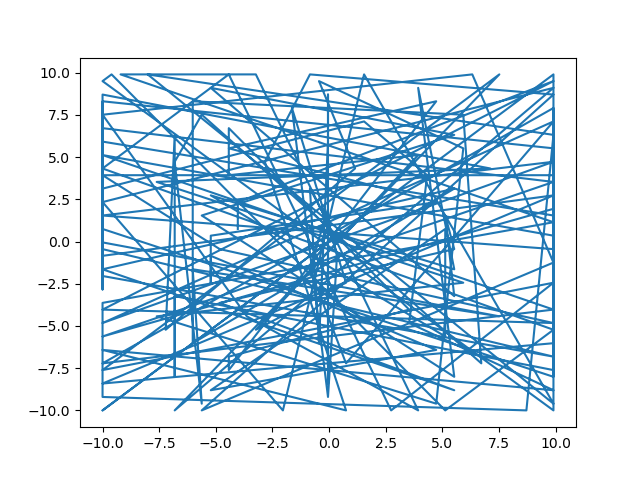

In [165]:
plt.plot(X_train[:,0],X_train[:,1])
plt.show()

In [166]:
def plot_wind_field(X, y1, y2, title, res):
    fig, ax = plt.subplots(1, 1)
    plt.axis('equal')
    plt.grid(linestyle=':')
    try:
        q = plt.quiver(X.numpy()[::res, 0], X.numpy()[::res, 1], y1.numpy()[::res], y2.numpy()[::res], scale=2.54, color='r',
                       units='width', scale_units="inches", width=0.003)
    except:
        q = plt.quiver(X[::res, 0], X[::res, 1], y1[::res], y2[::res], scale=2.54*2, color='r',
                       units='width', scale_units="inches", width=0.003)
    plt.title(title)
    plt.ioff()
    plt.show()

<IPython.core.display.Javascript object>


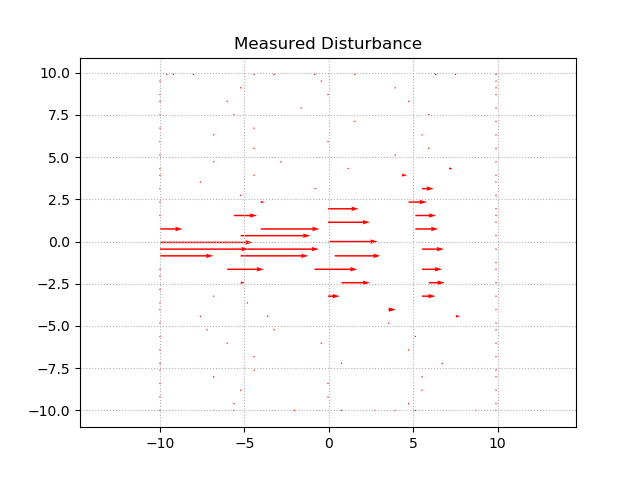

In [167]:
plot_wind_field(X_train, y1_train, y2_train, "Measured Disturbance",1)

In [168]:
# Prediction 
mean_pred1, std_pred1 = gaussian_process1.predict(X_grid, return_std=True)

In [169]:
# Prediction 
mean_pred2, std_pred2 = gaussian_process2.predict(X_grid, return_std=True)

<IPython.core.display.Javascript object>


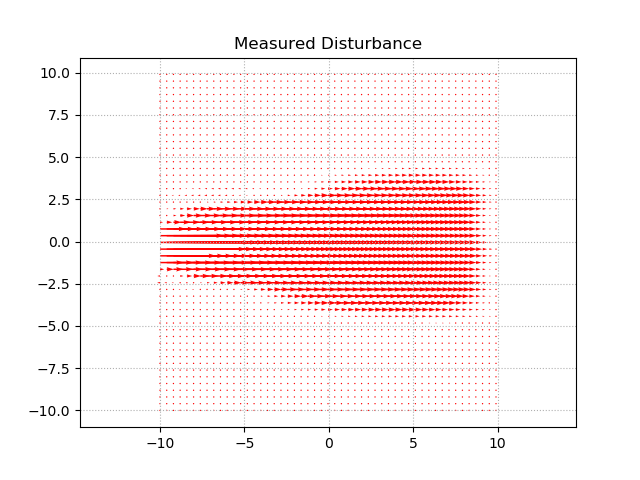

In [170]:
plot_wind_field(X_grid, mean_pred1, mean_pred2, "Measured Disturbance",1)

In [171]:
# Plot the uncertainties
def plot_surface(x, y, mean, upper, lower, bounds):
    mean_grid = mean.reshape(x.shape)
    fig = plt.figure()
    if bounds:
        upper_grid = upper.reshape(x.shape)
        lower_grid = lower.reshape(x.shape)
        ax = fig.gca(projection='3d')
        ax.plot_surface(x, y, mean_grid,  color='C0', alpha=0.8)
        ax.plot_surface(x, y, upper_grid, cmap=cm.coolwarm, alpha=0.5)
        ax.plot_surface(x, y, lower_grid, cmap=cm.coolwarm, alpha=0.5)
    else:
        ax1 = fig.subplots(1, 1)
        ax1 = plt.contourf(x, y, mean_grid)
        plt.colorbar(ax1)
    plt.ioff()
    plt.show()

In [172]:
upper1 = mean_pred1 + 1.96 * std_pred1
lower1 = mean_pred1 - 1.96 * std_pred1
upper2 = mean_pred2 + 1.96 * std_pred2
lower2 = mean_pred2 - 1.96 * std_pred2

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent

<IPython.core.display.Javascript object>


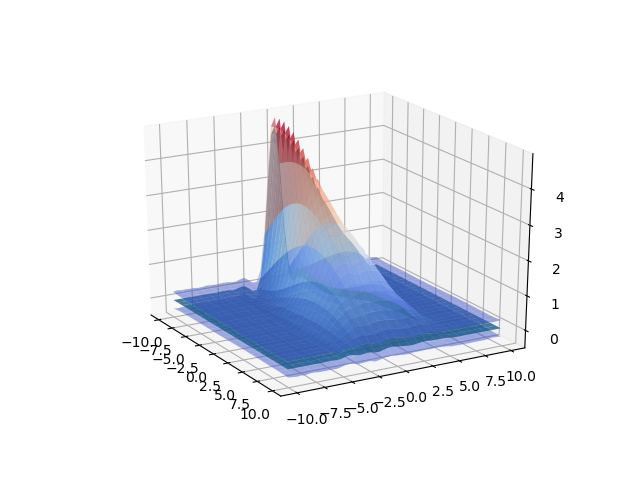

<IPython.core.display.Javascript object>


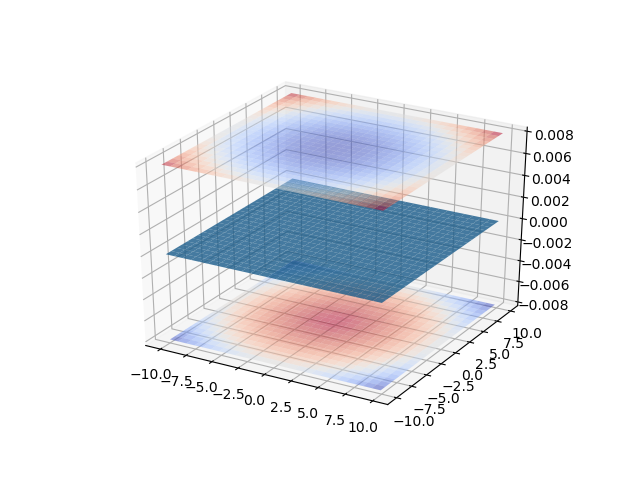

In [173]:
%matplotlib notebook
plot_surface(x_grid, y_grid, mean_pred1, upper1, lower1, True)
plot_surface(x_grid, y_grid, mean_pred2, upper2, lower2, True)

# Try traveling salesman approach 

In [317]:
n_initial = 9 # Initialize this with 5 random inputs (0,0) as starting one included
initial_idx = np.random.choice(range(len(X_grid)), size=n_initial, replace=False)
X_train = np.array([0,0])
y_train = wind_calculator.calculate_windfield([X_train[0], X_train[1], 2])
y1_train = np.array([y_train[0]])
y2_train = np.array([y_train[1]])
cities_dict = {}
cities_dict[0] = X_train

In [318]:
for i in range(initial_idx.size):
    X_add = X_grid[initial_idx[i]]
    X_train = np.vstack((X_train, X_add))
    cities_dict[i+1] = X_add

In [319]:
cities_dict

{0: array([0, 0]),
 1: array([-5.224, -4.03 ]),
 2: array([ 8.706, -4.03 ]),
 3: array([-7.214, -1.244]),
 4: array([ 8.706, -1.244]),
 5: array([-7.612, -2.438]),
 6: array([3.134, 1.542]),
 7: array([-2.04, -6.02]),
 8: array([ 6.318, -2.04 ]),
 9: array([-9.204, -1.244])}

In [320]:
print(X_train)

[[ 0.     0.   ]
 [-5.224 -4.03 ]
 [ 8.706 -4.03 ]
 [-7.214 -1.244]
 [ 8.706 -1.244]
 [-7.612 -2.438]
 [ 3.134  1.542]
 [-2.04  -6.02 ]
 [ 6.318 -2.04 ]
 [-9.204 -1.244]]


In [321]:
names_list = np.fromiter(cities_dict.keys(), dtype=int)
cities_list = X_train

In [322]:
# Parameters
n_cities = 10

n_population = 100

mutation_rate = 0.3

In [323]:
# Function to compute the distance between two points
def compute_city_distance_coordinates(a,b):
    return ((a[0]-b[0])**2+(a[1]-b[1])**2)**0.5
def compute_city_distance_names(city_a, city_b, cities_dict):
    return compute_city_distance_coordinates(cities_dict[city_a], cities_dict[city_b])

In [324]:
# First step: Create the first population set
def genesis(city_list, n_population):

    population_set = []
    for i in range(n_population):
        #Randomly generating a new solution
        sol_i = city_list[np.random.choice(list(range(n_cities)), n_cities, replace=False)]
        population_set.append(sol_i)
    return np.array(population_set)

population_set = genesis(names_list, n_population)
population_set



array([[5, 3, 0, 9, 7, 2, 6, 8, 1, 4],
       [4, 0, 8, 6, 5, 7, 1, 3, 9, 2],
       [8, 1, 3, 0, 4, 2, 9, 6, 7, 5],
       [3, 0, 7, 5, 9, 8, 6, 1, 4, 2],
       [9, 1, 0, 7, 6, 2, 8, 5, 3, 4],
       [6, 7, 5, 8, 1, 2, 9, 0, 3, 4],
       [2, 6, 8, 3, 0, 4, 1, 7, 5, 9],
       [4, 0, 8, 1, 3, 6, 5, 2, 7, 9],
       [3, 7, 4, 8, 0, 9, 6, 5, 1, 2],
       [3, 5, 4, 9, 7, 8, 6, 0, 2, 1],
       [9, 8, 5, 3, 4, 6, 1, 7, 0, 2],
       [4, 1, 6, 8, 9, 0, 2, 3, 7, 5],
       [0, 4, 5, 3, 8, 2, 6, 7, 1, 9],
       [6, 3, 5, 9, 2, 7, 0, 4, 8, 1],
       [1, 6, 7, 0, 8, 3, 2, 4, 5, 9],
       [2, 1, 3, 9, 0, 7, 4, 5, 8, 6],
       [6, 8, 4, 5, 9, 7, 2, 3, 1, 0],
       [7, 8, 1, 6, 0, 2, 5, 4, 9, 3],
       [9, 4, 7, 1, 0, 2, 3, 6, 5, 8],
       [9, 3, 8, 6, 0, 5, 7, 1, 2, 4],
       [0, 5, 1, 3, 6, 2, 8, 7, 4, 9],
       [3, 0, 4, 1, 5, 2, 6, 8, 9, 7],
       [2, 9, 0, 4, 5, 7, 6, 8, 1, 3],
       [6, 7, 4, 8, 9, 3, 1, 5, 0, 2],
       [5, 8, 7, 0, 4, 2, 9, 3, 6, 1],
       [3, 7, 6, 8, 9, 0,

In [325]:
def fitness_eval(city_list, cities_dict):
    total = 0
    for i in range(n_cities-1):
        a = city_list[i]
        b = city_list[i+1]
        total += compute_city_distance_names(a,b, cities_dict)
    return total


In [326]:
def get_all_fitnes(population_set, cities_dict):
    fitnes_list = np.zeros(n_population)

    #Looping over all solutions computing the fitness for each solution
    for i in  range(n_population):
        fitnes_list[i] = fitness_eval(population_set[i], cities_dict)

    return fitnes_list

fitnes_list = get_all_fitnes(population_set,cities_dict)
fitnes_list

array([ 75.99622708,  65.60340718,  80.59764262,  69.66265611,
        69.07767081, 106.01822357,  68.91747912,  88.67970472,
        78.1529332 ,  85.20638072,  82.63590529,  93.29439439,
        68.73409019,  72.39931787,  83.05810448,  81.83707044,
        71.38358529,  96.75801902, 101.8890325 ,  58.91841669,
        74.91837576,  86.41126966,  88.28439871,  64.85189943,
        82.00655114,  99.3874026 , 103.81054533,  95.65656347,
        73.63682595,  67.70711973,  87.02244692,  83.29433219,
        71.95547984,  94.42974639,  95.74435576,  66.41337256,
       105.31573761,  46.45048194,  83.67663149,  64.88435678,
        69.28640056,  74.70610305,  79.95668503,  70.86933169,
        94.51241475,  97.18150249, 103.55629301,  85.35068552,
        70.13682468,  50.9584375 ,  86.49650901,  64.78223835,
        89.02405469,  73.38139594,  80.05277573,  89.74022062,
        73.27119942,  94.07225846,  65.06269691,  93.06594111,
        97.47444961,  81.91499421,  94.14265072,  72.79

In [337]:
def progenitor_selection(population_set,fitnes_list):
    total_fit = fitnes_list.sum()
    prob_list = fitnes_list/total_fit
    
    #Notice there is the chance that a progenitor. mates with oneself
    progenitor_list_a = np.random.choice(list(range(len(population_set))), len(population_set),p=prob_list, replace=True)
    progenitor_list_b = np.random.choice(list(range(len(population_set))), len(population_set),p=prob_list, replace=True)
    
    progenitor_list_a = population_set[progenitor_list_a]
    progenitor_list_b = population_set[progenitor_list_b]
    
    
    return np.array([progenitor_list_a,progenitor_list_b])


progenitor_list = progenitor_selection(population_set,fitnes_list)
progenitor_list[0][2]

array([4, 8, 6, 5, 2, 3, 9, 1, 7, 0])

In [338]:
def mate_progenitors(prog_a, prog_b):
    offspring = prog_a[0:5]

    for city in prog_b:

        if not city in offspring:
            offspring = np.concatenate((offspring,[city]))

    return offspring
            
    
    
def mate_population(progenitor_list):
    new_population_set = []
    for i in range(progenitor_list.shape[1]):
        prog_a, prog_b = progenitor_list[0][i], progenitor_list[1][i]
        offspring = mate_progenitors(prog_a, prog_b)
        new_population_set.append(offspring)
        
    return new_population_set

new_population_set = mate_population(progenitor_list)
new_population_set[0]

array([4, 5, 9, 6, 1, 8, 2, 3, 0, 7])

In [339]:
def mutate_offspring(offspring):
    for q in range(int(n_cities*mutation_rate)):
        a = np.random.randint(0,n_cities)
        b = np.random.randint(0,n_cities)

        offspring[a], offspring[b] = offspring[b], offspring[a]

    return offspring
    
    
def mutate_population(new_population_set):
    mutated_pop = []
    for offspring in new_population_set:
        mutated_pop.append(mutate_offspring(offspring))
    return mutated_pop

mutated_pop = mutate_population(new_population_set)
mutated_pop[0]



array([1, 5, 9, 6, 2, 8, 7, 3, 0, 4])

In [345]:
best_solution = [-1,np.inf,np.array([])]
for i in range(10000):
    if i%1000==0: print(i, fitnes_list.min(), fitnes_list.mean())
    fitnes_list = get_all_fitnes(mutated_pop,cities_dict)
    
    #Saving the best solution
    if fitnes_list.min() < best_solution[1]:
        best_solution[0] = i
        best_solution[1] = fitnes_list.min()
        best_solution[2] = np.array(mutated_pop)[fitnes_list.min() == fitnes_list]
    
    progenitor_list = progenitor_selection(population_set,fitnes_list)
    new_population_set = mate_population(progenitor_list)
    
    mutated_pop = mutate_population(new_population_set)



0 46.768331948744255 80.88498698941119
1000 51.201903731965444 82.67415204130853
2000 50.2658241281816 80.4995391892824
3000 44.863624909278315 79.07337511231499
4000 43.17569631051845 79.96585524544092
5000 52.73563485040142 81.04382213970551
6000 51.82602860736316 83.68913015695425
7000 51.8109693953367 80.99476983047862
8000 55.38285214166572 80.0683809376073
9000 48.978821650669204 84.22386568984152


In [346]:
print(best_solution)
order = best_solution[2][0,:]

[8364, 30.371830632718147, array([[2, 4, 8, 6, 0, 7, 1, 3, 5, 9]])]


<IPython.core.display.Javascript object>


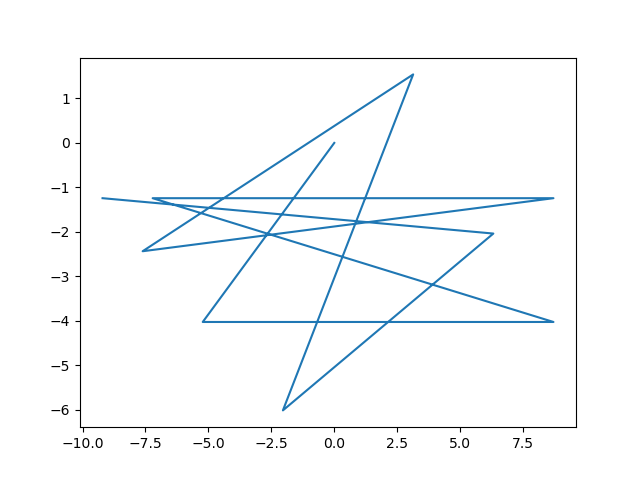

In [347]:
plt.plot(X_train[:,0],X_train[:,1])
plt.show()

In [348]:
X_train_sort = np.zeros(X_train.shape)
for i in cities_dict.keys():
    X_train_sort[i,:] = cities_dict[order[i]]

<IPython.core.display.Javascript object>


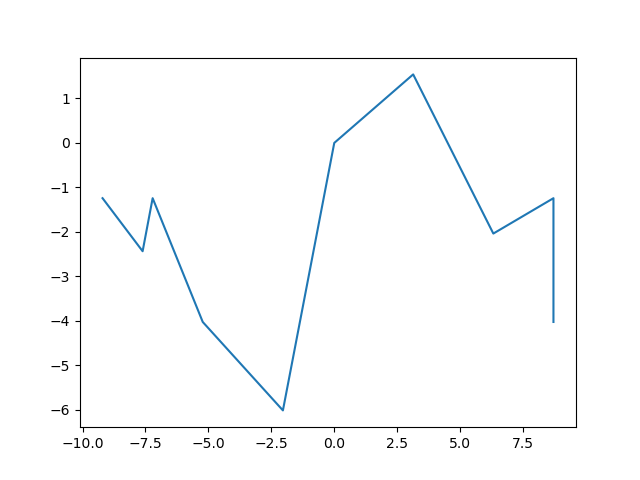

In [349]:
plt.plot(X_train_sort[:,0],X_train_sort[:,1])
plt.show()

In [350]:
print(X_train_sort[:,0], X_train_sort[:,1])

[ 8.706  8.706  6.318  3.134  0.    -2.04  -5.224 -7.214 -7.612 -9.204] [-4.03  -1.244 -2.04   1.542  0.    -6.02  -4.03  -1.244 -2.438 -1.244]
